In [70]:
import scanpy as sc
import pandas as pd
import numpy as np

#import math #計算combinations
import random #做隨機抽樣分布

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.stats import norm


from tqdm import tqdm

import csv

In [71]:
healthy = sc.read_h5ad("GSE174188/GSE174188_Healthy.h5ad")
merge_data = sc.read_h5ad("bbknn_GSE165080_GSE149689_GSE227991_gene_intersection_with_GSE174188.h5ad")
healthy

AnnData object with n_obs × n_vars = 486418 × 1999
    obs: 'batch_cov', 'ind_cov', 'Processing_Cohort', 'louvain', 'cg_cov', 'ct_cov', 'L3', 'ind_cov_batch_cov', 'Age', 'Sex', 'pop_cov', 'Status', 'SLE_status', 'cell_type', 'cell_type_l1'
    var: 'gene_ids'
    uns: 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [72]:
# 寫檔，提取我需要的東西，減少h5ad的檔案大小

import anndata
import scanpy as sc


#healthy = sc.read_h5ad("GSE174188/GSE174188_CLUES1_adjusted.h5ad")
healthy = healthy[healthy.obs.Status == "Healthy", :]

# 新建欄位把cell type做我要的分類
def classify_cell_type(value):
    if value == "pDC" or value == "cDC":
        return "DC"
    elif value == "cM" or value == "ncM":
        return "Monocyte"
    elif value == "T4":
        return "CD4 T"
    elif value == "T8":
        return "CD8 T"
    else:
        return value
    if value == "cM":
        return "cM"
    
healthy.obs["cell_type_l1"] = healthy.obs["cg_cov"].apply(classify_cell_type)


C:\Users\benson\AppData\Local\Temp\ipykernel_337408\686239307.py:25: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  healthy.obs["cell_type_l1"] = healthy.obs["cg_cov"].apply(classify_cell_type)


In [76]:
common_gene = set(healthy.var.index).intersection(set(merge_data.var.index))
len(common_gene)

1160

In [77]:
# 假設你的AnnData物件叫做adata，你想要選取的基因列表叫做gene_list
healthy = healthy[:, healthy.var_names.isin(common_gene)]
healthy

View of AnnData object with n_obs × n_vars = 486418 × 1160
    obs: 'batch_cov', 'ind_cov', 'Processing_Cohort', 'louvain', 'cg_cov', 'ct_cov', 'L3', 'ind_cov_batch_cov', 'Age', 'Sex', 'pop_cov', 'Status', 'SLE_status', 'cell_type', 'cell_type_l1'
    var: 'gene_ids'
    uns: 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [78]:
cell_type = list(set(healthy.obs.cell_type))
cell_type

['CD8 T', 'NK', 'DC', 'Progen', 'CD4 T', 'PB', 'B', 'Prolif', 'Monocyte']

In [83]:
healthy

View of AnnData object with n_obs × n_vars = 486418 × 1160
    obs: 'batch_cov', 'ind_cov', 'Processing_Cohort', 'louvain', 'cg_cov', 'ct_cov', 'L3', 'ind_cov_batch_cov', 'Age', 'Sex', 'pop_cov', 'Status', 'SLE_status', 'cell_type', 'cell_type_l1'
    var: 'gene_ids'
    uns: 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

C:\ProgramData\anaconda3\Lib\site-packages\anndata\_core\anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
C:\ProgramData\anaconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


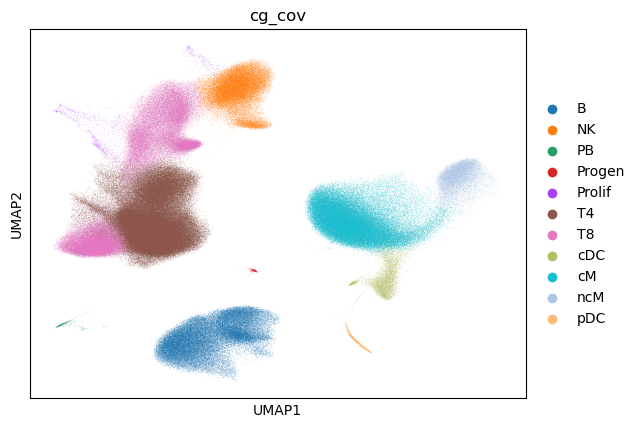

In [84]:
sc.pl.umap(healthy, color = "cg_cov")

C:\ProgramData\anaconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


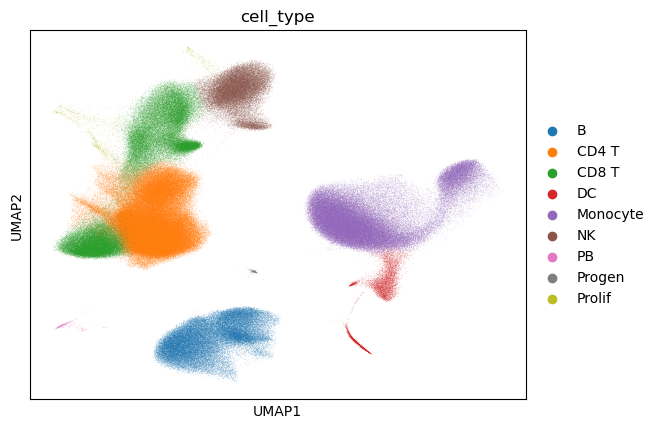

In [29]:
sc.pl.umap(healthy, color = "cell_type")

# 將細胞數量過少的移除
#### 總細胞數 < 1% remove
#### 總cell type數 < 1% remove

In [85]:
sample = list(set(healthy.obs.ind_cov))

rows_to_remove = []
for i in sample:
    healthy = healthy[healthy.obs.Status == "Healthy", :]
    if healthy[healthy.obs.ind_cov == i,:].n_obs < healthy.n_obs*0.005:
        rows_to_remove.append(i)
healthy_filter = healthy[~healthy.obs.ind_cov.isin(rows_to_remove),:]    
    
print(healthy_filter)

View of AnnData object with n_obs × n_vars = 474740 × 1160
    obs: 'batch_cov', 'ind_cov', 'Processing_Cohort', 'louvain', 'cg_cov', 'ct_cov', 'L3', 'ind_cov_batch_cov', 'Age', 'Sex', 'pop_cov', 'Status', 'SLE_status', 'cell_type', 'cell_type_l1'
    var: 'gene_ids'
    uns: 'neighbors', 'pca', 'rank_genes_groups', 'umap', 'cg_cov_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'


# 開始處理cell dispersion

我需要先把每個人的部分個別提取出來，最後再將每個人的NK提取出來做cell dispersion

In [86]:
sample = list(set(healthy_filter.obs.ind_cov))

personal = {}
for i in sample:
    if i not in personal:
        personal[i] = healthy[healthy.obs.ind_cov == i, :]
len(personal)

92

In [31]:
personal["HC-572"]

View of AnnData object with n_obs × n_vars = 5248 × 1160
    obs: 'batch_cov', 'ind_cov', 'Processing_Cohort', 'louvain', 'cg_cov', 'ct_cov', 'L3', 'ind_cov_batch_cov', 'Age', 'Sex', 'pop_cov', 'Status', 'SLE_status', 'cell_type', 'cell_type_l1'
    var: 'gene_ids'
    uns: 'neighbors', 'pca', 'rank_genes_groups', 'umap', 'cg_cov_colors', 'cell_type_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [87]:
# 將personal進行排序
sorted_personal = dict(sorted(personal.items(), key=lambda x: x[1].obs.Age[0]))
# 排序之後取得年齡
age = []
for i in sorted_personal:
    age.append(sorted_personal[i].obs.Age[0])

# Cell Dispersion Calculate

In [100]:
# 將30~50個不同的cell放入新的dataframe中，以便後續進行計算
def renew_sampling_list(cell_type, minimum):
    # 隨機抽樣，抽取50個不同的cell之後要做cell dispersion的計算
    sampling = []
    for i in range(0, int(min(1/2*minimum,50))):
        # 挑出cell的位置
        cell = random.randrange(0, cell_type.n_obs)
        while cell in sampling:
            cell = random.randrange(0, cell_type.n_obs)
        sampling.append(cell)

    # 紀錄50個cell * gene的資料
    cell_dispersion = []
    # 先將 cell type 變成dataframe後，做 transpose 之後才能夠把挑選出來的 genes 放進去
    cell_type_transpose = pd.DataFrame(data = cell_type.X, columns = cell_type.var.index.values)
    # 做50次的隨機抽樣並且將結果
    for i in range(0, int(min(1/2*minimum, 50))):
        # 將dataframe塞進去新的list中
        cell_dispersion.append(cell_type_transpose.loc[sampling[i]])
    #將list轉成dataframe的格式
    cell_dispersion = np.array(cell_dispersion)

    return cell_dispersion

# 將某一個人的 cell type 提取出來做cell dispersion, 之後再拿其他人的去做比較
# 要給numpy array的格式
def create_distance_matrix(data):
    # must be two dimension array, so need to change dataframe into array
    ncells = data.shape[0]

    # matric 會是aaabbbccc
    index1 = np.concatenate(tuple(np.repeat(i, ncells) for i in range(0,ncells)), axis =None)
    # matirc 會是abcabcabc
    index2 = np.tile(np.arange(0, ncells, 1), ncells)

    X = data[:, index1]
    Y = data[:, index2]

    # Euclidean Distance
    out = np.sqrt(np.sum((X - Y) * (X - Y), axis = 0))

    distance_matrix = np.reshape(out, (ncells, ncells))

    return distance_matrix

# 計算離散程度，將n*n計算過後的matrix丟進來
def calculate_dispersion(distance):
    # np.triu只取上三角，其餘的都變成0
    # np.count_nonzero 計算非0的部分有多少個
    dispersion = np.triu(distance).sum()/np.count_nonzero(np.triu(distance))
    return dispersion


# 將上面的所有的function合併成這個function執行
def Excute_all(sorted_personal, cell_type_name):# cell_type_name是字串的型態

    pbar = tqdm(total = len(sorted_personal))

    dispersion_personal = []
    mean = []
    distance = []
    # 總共人數
    for i in sorted_personal:
        # Data augmentation for 10 times
        # 挑出最小值
        minimum = 50
        # 取得所需的cell type 以及 random select 80% anndata
        #random_select_anndata = data_sampling_size(sorted_personal[i][sorted_personal[i].obs.cell_type_l1 == cell_type_name, :], select_size = 0.8)
        
        a = sorted_personal[i][sorted_personal[i].obs.cell_type_l1 == cell_type_name, :].obs
        cell_type = sorted_personal[i][sorted_personal[i].obs.cell_type_l1 == cell_type_name, :]
        if len(a) < minimum:
            minimum = len(a)

        dispersion = []
        # 1000 times sampling
        for j in range(0,1000):
            # 取得sampling的dataframe
            cell_dispersion = renew_sampling_list(cell_type, minimum)
            # 計算 cell * cell distance
            distance_matrix = create_distance_matrix(cell_dispersion)
            # 取得此次抽樣的dispersion
            dispersion.append(calculate_dispersion(distance_matrix))


        distance.append(distance_matrix)

        dispersion_personal.append(dispersion)
        mean.append(np.mean(dispersion))

        pbar.update()
    pbar.close()

    # 計算標準差
    count = 0
    std = [] # 每一個人的標準差
    for i in range(len(distance)):
        count = (distance[i]-mean[i]) * (distance[i]-mean[i])
        std.append(np.sqrt(np.sum(count)/(len(distance)*((len(distance[i])*(len(distance[i])-1))/2)-1)))


    return dispersion_personal, mean, std

# 結果畫圖

In [101]:
def scatter_plot(data, title, cell_type):
    # 獲取所有的顏色名稱
    #all_colors = list(mcolors.CSS4_COLORS.keys())

    # 隨機選擇11種顏色
    #colors = np.random.choice(all_colors, size=11)
    cmap = plt.get_cmap('nipy_spectral', len(personal))

    for i in range(len(personal)):
        # 假設 x 軸是數據的索引，y 軸是數據的值
        x = int(float(age[i]))
        y = data[i]

         # 使用 plt.scatter 方法來創建散點圖
        plt.scatter(x, y, color = cmap(i))

    # 給圖表加上標題和軸標籤
    plt.title(title)
    
    # 這將 x 軸的刻度標籤大小設置為 8
    plt.tick_params(axis='x', labelsize=8)  
    # 這將 x 軸的刻度標籤旋轉 60 度
    plt.xticks(rotation = 60)  
    
    plt.xlabel('Age', fontsize = 14)
    plt.ylabel('Value', fontsize = 14)

    # 添加圖例
    plt.legend(age, fontsize = 6, bbox_to_anchor = (1.05, 1), loc = 'upper left', ncol = 4)
    
    # 將圖形保存為PNG文件
    #plt.savefig(f'Result_picture/GSE174188/Cell dispersion/Scatter_plot_{cell_type}.png', dpi=900)

    
    
    # 顯示圖表
    plt.show()
    

def errorbar(mean, std, title, cell_type):
    # 獲取所有的顏色名稱
    #all_colors = list(mcolors.CSS4_COLORS.keys())

    # 隨機選擇11種顏色
    #colors = np.random.choice(all_colors, size=11)
    cmap = plt.get_cmap('nipy_spectral', len(personal))

    for i in range(len(personal)):
        # 假設 x 軸是數據的索引，y 軸是數據的值
        x = int(float(age[i]))
        y = mean[i]

         # 使用 plt.scatter 方法來創建散點圖
        plt.errorbar(x, y, yerr = std[i], color = cmap(i), fmt = 'o')

    # 這將 x 軸的刻度標籤大小設置為 8
    plt.tick_params(axis='x', labelsize=8)  
    # 這將 x 軸的刻度標籤旋轉 60 度
    plt.xticks(rotation = 60)
        
    # 計算趨勢線的參數
    z = np.polyfit([int(float(a)) for a in age], mean, 1)
    # 創建一個多項式函數
    p = np.poly1d(z)
    print("斜率 :",p)
    test = list(set([int(float(a)) for a in age]))
    # 在圖中添加趨勢線
    plt.plot(test, p(test), 'r--', label='Trend Line')
    
    
    # 給圖表加上標題和軸標籤
    plt.title(title, fontsize = 16)
    plt.xlabel('Age', fontsize = 14)
    plt.ylabel('Dispersion', fontsize = 14)

    # 添加圖例
    plt.legend(["Trand Line"] + age, fontsize = 6, bbox_to_anchor=(1.05, 1), loc='upper left', ncol = 4)
    
    # 將圖形保存為PNG文件
    plt.savefig(f'Result_picture/GSE174188/Cell dispersion/Cell Dispersion_{cell_type}_intersection.png', dpi=300, bbox_inches='tight')

    # 顯示圖表
    plt.show()
    
def distribution(mean, std, age, cell_type):
    for i in range(0, len(mean)):
        x = np.arange(-4, 10, 0.001)
        y = norm.pdf(x, mean[i], std[i])
        plt.plot(x,y)
    
    # 添加圖例
    plt.legend(age, fontsize = 8, bbox_to_anchor = (1.05, 1), loc = 'upper left', ncol = 4)
    # 添加標題和軸標籤
    plt.title(f"{cell_type} cell dispersion", fontsize = 16)
    plt.xlabel('Different Sample', fontsize = 14)
    plt.ylabel('Probability Density', fontsize = 14)


    # 將圖形保存為PNG文件
    plt.savefig(f'Result_picture/GSE174188/Cell dispersion/{cell_type} cell dispersion_intersection.png', dpi=300, bbox_inches='tight')

# 確認細胞數量

In [41]:
# 確認細胞數量
a = []
for i in sorted_personal:
    a.append(sorted_personal[i][sorted_personal[i].obs.cell_type == "DC",:])
    if len(sorted_personal[i][sorted_personal[i].obs.cell_type == "DC",:]) <= 1:
        print(i)
for i in range(len(a)):
    #print(a[i].n_obs)
    0

# 測試用~ncM(non-classical monocytes)有一個人只有一顆cell，PB(Plasmablast)過少,Progen(CD34+ progenitor)過少，pDC(plamacytoid DC)過少
# Prolif(Proliferating lymphocytes)過少,cDC(conventional DC)有一個人只有一顆cell

# 只有T4, T8, NK, cM, B是夠的

# cM cell dispersion
    anndata.obs.cg_cov
    執行完要從function那邊改回來

dispersion_personal_cM, mean_cM, std_cM = Excute_all(sorted_personal, "cM")

np.mean(dispersion_personal_cM[0])

scatter_plot(mean_cM, "Cell Dispersion in cM", "cM")

errorbar(mean_cM, std_cM, "Cell Dispersion cM", "cM")

distribution(mean_cM, std_cM, age, "cM")

# NK cell dispersion

In [102]:
dispersion_personal_NK, mean_NK, std_NK = Excute_all(sorted_personal, "NK")

100%|██████████| 92/92 [01:21<00:00,  1.13it/s]


In [103]:
np.mean(dispersion_personal_NK[0])

5.229817261149088

In [44]:
'''count = 0
for i in sorted_personal:
    print(i)
    print("Age : ", age[count])
    print("Mean : ",mean_NK[count])
    print("Standard Deviation : ", std_NK[count], "\n")
    
    count += 1 '''

'count = 0\nfor i in sorted_personal:\n    print(i)\n    print("Age : ", age[count])\n    print("Mean : ",mean_NK[count])\n    print("Standard Deviation : ", std_NK[count], "\n")\n    \n    count += 1 '

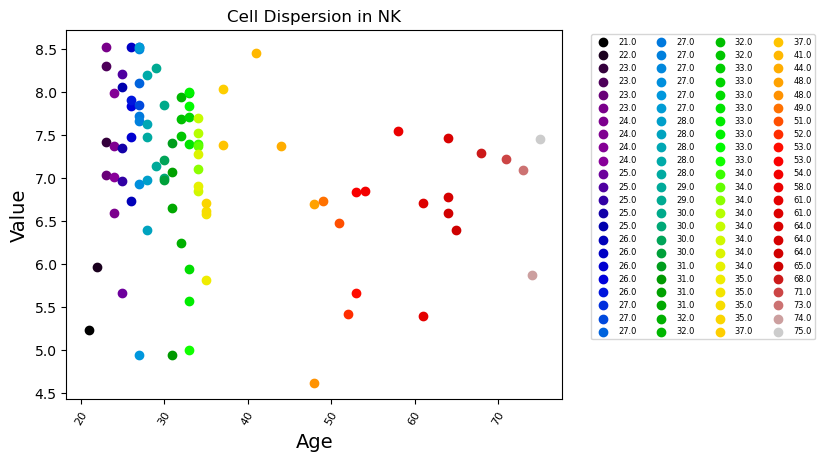

In [104]:
scatter_plot(mean_NK, "Cell Dispersion in NK", "NK")

斜率 :  
-0.01629 x + 7.687


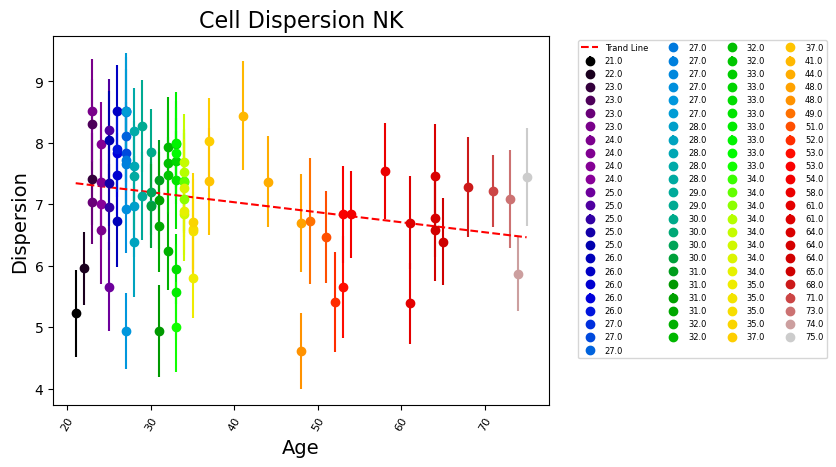

In [105]:
errorbar(mean_NK, std_NK, "Cell Dispersion NK", "NK")

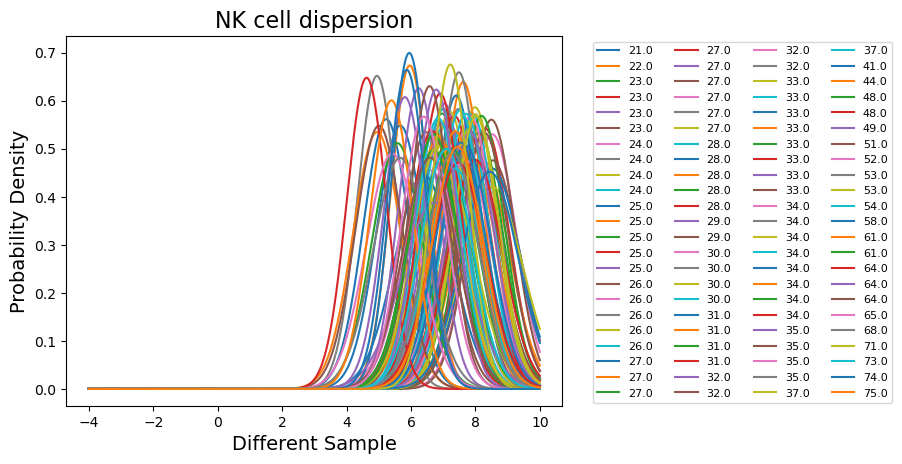

In [106]:
distribution(mean_NK, std_NK, age, "NK")

# Monocyte cell dispersion

In [107]:
dispersion_personal_Monocyte, mean_Monocyte, std_Monocyte = Excute_all(sorted_personal, "Monocyte")

100%|██████████| 92/92 [02:19<00:00,  1.52s/it]


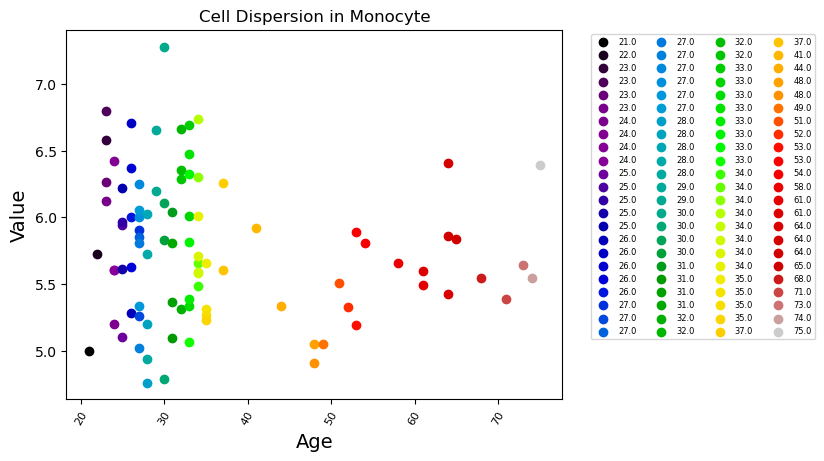

In [108]:
scatter_plot(mean_Monocyte, "Cell Dispersion in Monocyte", "Monocyte")

斜率 :  
-0.004987 x + 5.947


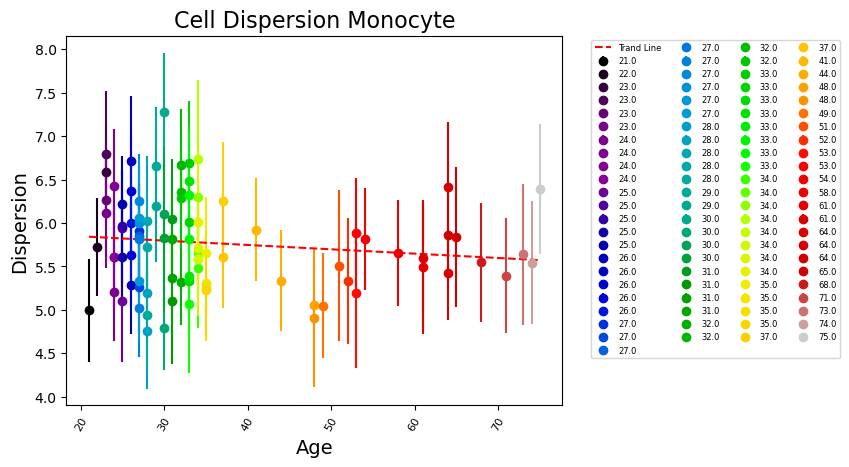

In [109]:
errorbar(mean_Monocyte, std_Monocyte, "Cell Dispersion Monocyte", "Monocyte")

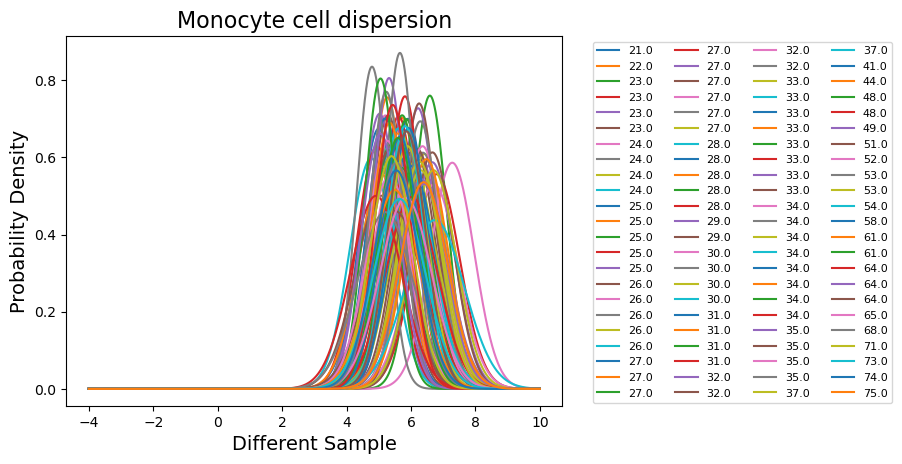

In [110]:
distribution(mean_Monocyte, std_Monocyte, age, "Monocyte")

# CD4 T cell dispersion

In [111]:
dispersion_personal_CD4T, mean_CD4T, std_CD4T = Excute_all(sorted_personal, "CD4 T")

100%|██████████| 92/92 [03:38<00:00,  2.37s/it]


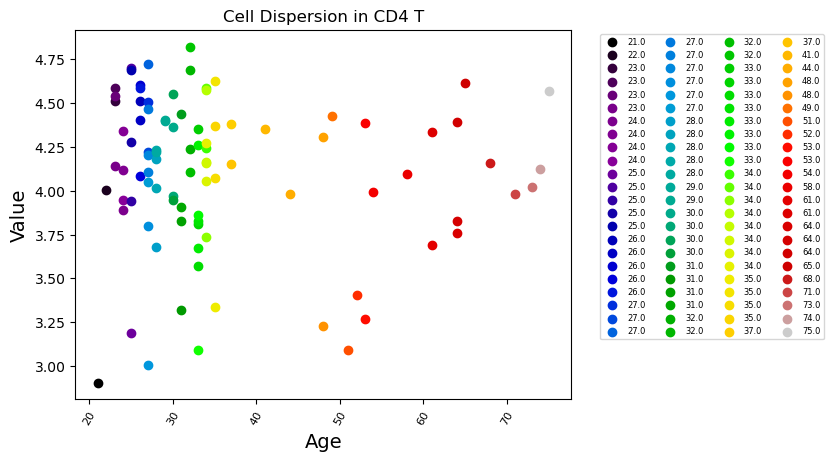

In [112]:
scatter_plot(mean_CD4T, "Cell Dispersion in CD4 T", "CD4 T")

斜率 :  
-0.002599 x + 4.198


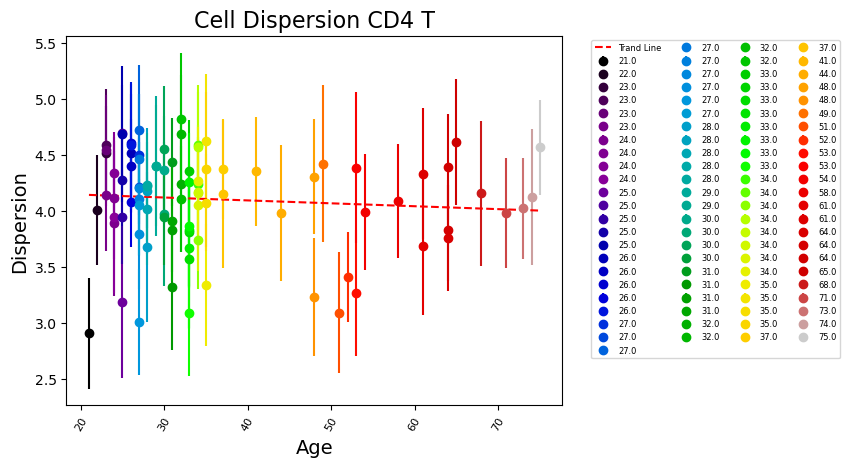

In [113]:
errorbar(mean_CD4T, std_CD4T, "Cell Dispersion CD4 T", "CD4 T")

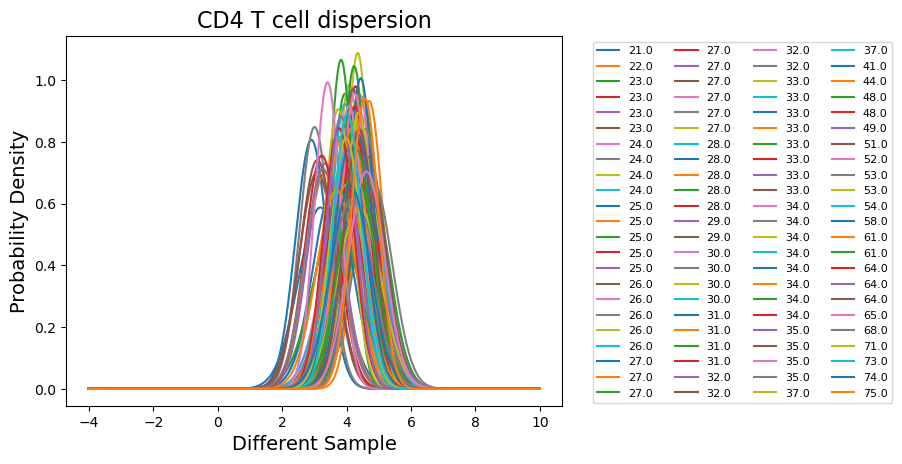

In [114]:
distribution(mean_CD4T, std_CD4T, age, "CD4 T")

# CD8 T cell dispersion

In [115]:
dispersion_personal_CD8T, mean_CD8T, std_CD8T = Excute_all(sorted_personal, "CD8 T")

100%|██████████| 92/92 [02:06<00:00,  1.38s/it]


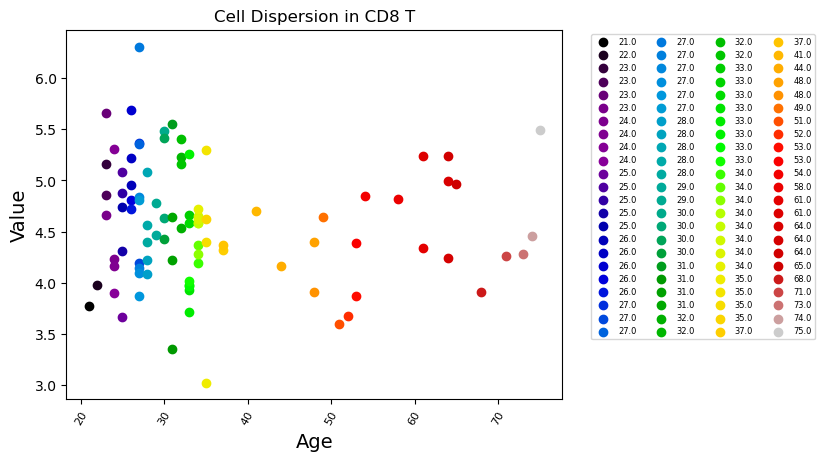

In [116]:
scatter_plot(mean_CD8T, "Cell Dispersion in CD8 T", "CD8 T")

斜率 :  
-0.003066 x + 4.687


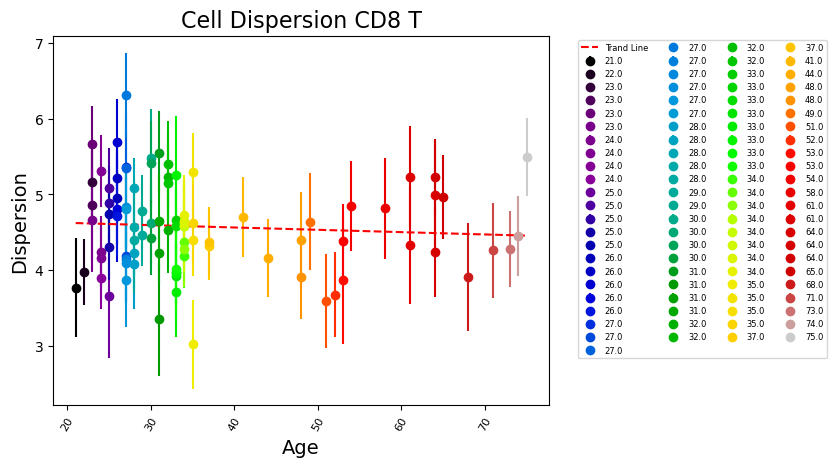

In [117]:
errorbar(mean_CD8T, std_CD8T, "Cell Dispersion CD8 T", "CD8 T")

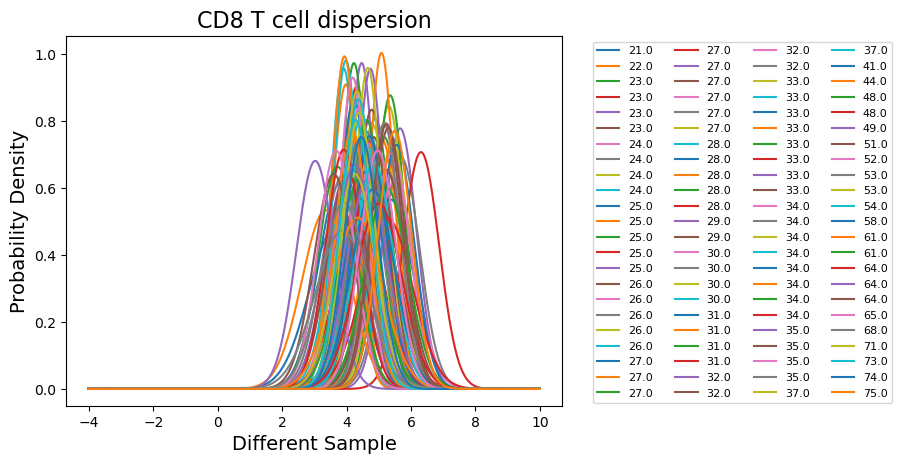

In [118]:
distribution(mean_CD8T, std_CD8T, age, "CD8 T")

# B cell dispersion

In [119]:
dispersion_personal_B, mean_B, std_B = Excute_all(sorted_personal, "B")

100%|██████████| 92/92 [01:43<00:00,  1.13s/it]


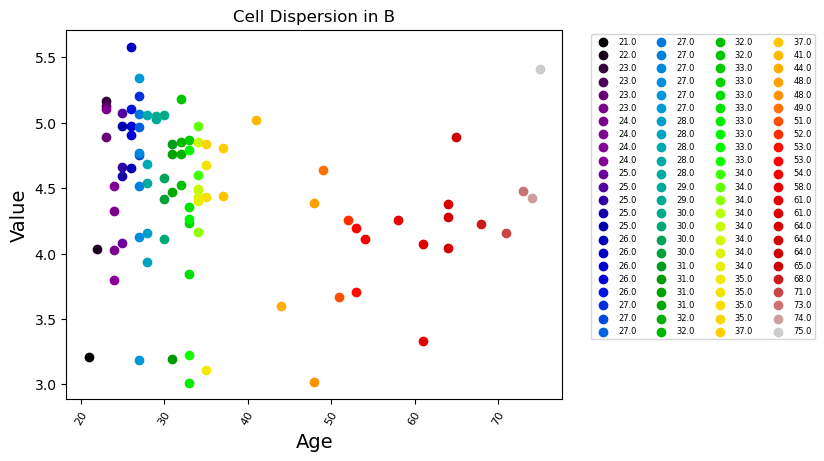

In [120]:
scatter_plot(mean_B, "Cell Dispersion in B", "B")

斜率 :  
-0.00809 x + 4.748


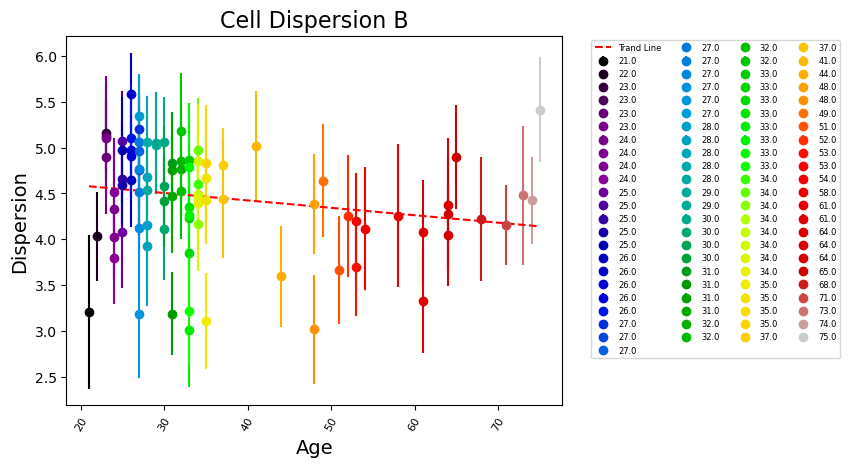

In [121]:
errorbar(mean_B, std_B, "Cell Dispersion B", "B")

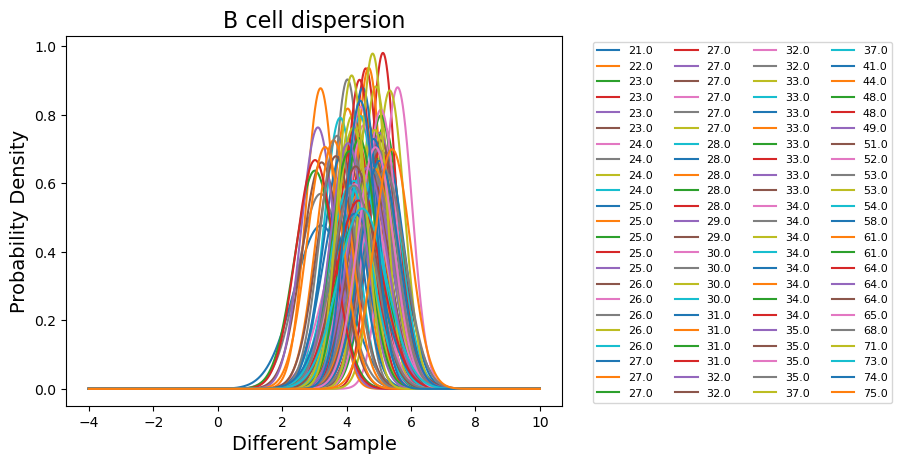

In [122]:
distribution(mean_B, std_B, age, "B")

# DC cell dispersion

In [123]:
dispersion_personal_DC, mean_DC, std_DC = Excute_all(sorted_personal, "DC")

100%|██████████| 92/92 [00:54<00:00,  1.69it/s]


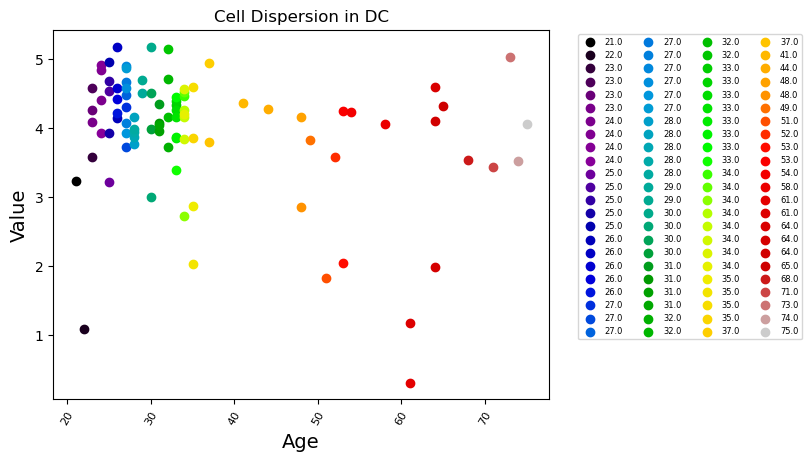

In [124]:
scatter_plot(mean_DC, "Cell Dispersion in DC", "DC")

斜率 :  
-0.01942 x + 4.668


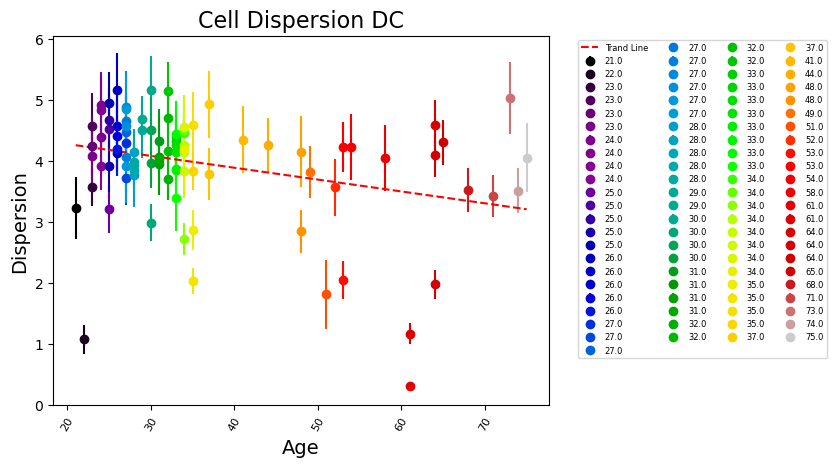

In [125]:
errorbar(mean_DC, std_DC, "Cell Dispersion DC", "DC")

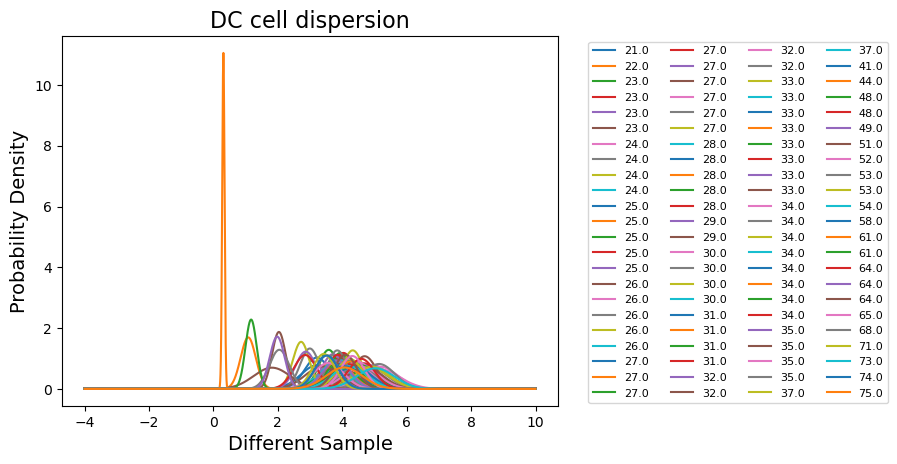

In [126]:
distribution(mean_DC, std_DC, age, "DC")

In [68]:
healthy

View of AnnData object with n_obs × n_vars = 486418 × 1160
    obs: 'batch_cov', 'ind_cov', 'Processing_Cohort', 'louvain', 'cg_cov', 'ct_cov', 'L3', 'ind_cov_batch_cov', 'Age', 'Sex', 'pop_cov', 'Status', 'SLE_status', 'cell_type', 'cell_type_l1'
    var: 'gene_ids'
    uns: 'neighbors', 'pca', 'rank_genes_groups', 'umap', 'cg_cov_colors', 'cell_type_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

# Mean & Std寫檔

In [141]:
import csv
with open('mean_and_stdev_GSE174188_intersection_with_GSE165080_GSE149689_GSE227991.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    # 寫入列名
    writer.writerow([''] + ['age', 'mean_NK', 'mean_CD4T', 'mean_CD8T', 'mean_B', 'mean_Monocyte', 'mean_DC', 'std_NK', 'std_CD4T', 'std_CD8T', 'std_B', 'std_Monocyte', 'std_DC'])    
    # 寫入數據
    for sample, Age, Mean_NK, Mean_CD4T, Mean_CD8T, Mean_B, Mean_Monocyte, Mean_DC, Std_NK, Std_CD4T, Std_CD8T, Std_B, Std_Monocyte, Std_DC in zip(sorted_personal, age, mean_NK, mean_CD4T, mean_CD8T, mean_B, mean_Monocyte, mean_DC, std_NK, std_CD4T, std_CD8T, std_B, std_Monocyte, std_DC):
        writer.writerow([sample] + [Age, Mean_NK, Mean_CD4T, Mean_CD8T, Mean_B, Mean_Monocyte, Mean_DC, Std_NK, Std_CD4T, Std_CD8T, Std_B, Std_Monocyte, Std_DC])

In [133]:
# 繪製直方圖
#plt.hist(dispersion_NK, bins=30, density=True)
#plt.xlabel('Dispersion')
#plt.ylabel('Probability Density')

# 測試

In [ ]:
# 挑選80%的細胞出來要做data augmentation
def data_sampling_size(adata, select_size = 0.8):
    total_cells = adata.shape[0]
    subset_cells = int(total_cells * select_size)
    # 隨機選擇索引
    subset_indices = np.random.choice(total_cells, subset_cells, replace=False)

    return adata[subset_indices, :]

# 將30~50個不同的cell放入新的dataframe中，以便後續進行計算
def renew_sampling_list(cell_type, minimum):
    # 隨機抽樣，抽取50個不同的cell之後要做cell dispersion的計算
    sampling = []
    for i in range(0, int(min(1/2*minimum,50))):
        # 挑出cell的位置
        cell = random.randrange(0, cell_type.n_obs)
        while cell in sampling:
            cell = random.randrange(0, cell_type.n_obs)
        sampling.append(cell)

    # 紀錄50個cell * gene的資料
    cell_dispersion = []
    # 先將 cell type 變成dataframe後，做 transpose 之後才能夠把挑選出來的 genes 放進去
    cell_type_transpose = pd.DataFrame(data = cell_type.X, columns = cell_type.var.index.values)
    # 做50次的隨機抽樣並且將結果
    for i in range(0, int(min(1/2*minimum, 50))):
        # 將dataframe塞進去新的list中
        cell_dispersion.append(cell_type_transpose.loc[sampling[i]])
    #將list轉成dataframe的格式
    cell_dispersion = np.array(cell_dispersion)

    return cell_dispersion

# 將某一個人的 cell type 提取出來做cell dispersion, 之後再拿其他人的去做比較
# 要給numpy array的格式
def create_distance_matrix(data):
    # must be two dimension array, so need to change dataframe into array
    ncells = data.shape[0]

    # matric 會是aaabbbccc
    index1 = np.concatenate(tuple(np.repeat(i, ncells) for i in range(0,ncells)), axis =None)
    # matirc 會是abcabcabc
    index2 = np.tile(np.arange(0, ncells, 1), ncells)

    X = data[:, index1]
    Y = data[:, index2]

    # Euclidean Distance
    out = np.sqrt(np.sum((X - Y) * (X - Y), axis = 0))

    distance_matrix = np.reshape(out, (ncells, ncells))

    return distance_matrix

# 計算離散程度，將n*n計算過後的matrix丟進來
def calculate_dispersion(distance):
    # np.triu只取上三角，其餘的都變成0
    # np.count_nonzero 計算非0的部分有多少個
    dispersion = np.triu(distance).sum()/np.count_nonzero(np.triu(distance))
    return dispersion


# 將上面的所有的function合併成這個function執行
def Excute_all(sorted_personal, cell_type_name):# cell_type_name是字串的型態

    pbar = tqdm(total = len(sorted_personal))

    dispersion_personal = []
    mean = []
    distance = []
    # 總共人數
    for i in sorted_personal:
        # Data augmentation for 10 times
        # 挑出最小值
        minimum = 50
        # 取得所需的cell type 以及 random select 80% anndata
        #random_select_anndata = data_sampling_size(sorted_personal[i][sorted_personal[i].obs.cell_type_l1 == cell_type_name, :], select_size = 0.8)
        
        a = sorted_personal[i][sorted_personal[i].obs.cell_type_l1 == cell_type_name, :].obs
        cell_type = sorted_personal[i][sorted_personal[i].obs.cell_type_l1 == cell_type_name, :]
        if len(a) < minimum:
            minimum = len(a)

        dispersion = []
        # 1000 times sampling
        for j in range(0,1000):
            # 取得sampling的dataframe
            cell_dispersion = renew_sampling_list(cell_type, minimum)
            # 計算 cell * cell distance
            distance_matrix = create_distance_matrix(cell_dispersion)
            # 取得此次抽樣的dispersion
            dispersion.append(calculate_dispersion(distance_matrix))


            distance.append(distance_matrix)

            dispersion_personal.append(dispersion)
            mean.append(np.mean(dispersion))

            pbar.update()
    pbar.close()

    # 計算標準差
    count = 0
    std = [] # 每一個人的標準差
    for i in range(len(distance)):
        count = (distance[i]-mean[i]) * (distance[i]-mean[i])
        std.append(np.sqrt(np.sum(count)/(len(distance)*((len(distance[i])*(len(distance[i])-1))/2)-1)))


    return dispersion_personal, mean, std

merge_data = sc.read_h5ad("GSE174188/GSE174188_gene_intersection_with_GSE165080_GSE149689_GSE227991.h5ad")

cell_type = list(set(merge_data.obs.cell_type_l1))

sample = list(set(merge_data.obs.ind_cov))

rows_to_remove = []
for i in sample:
    merge_data = merge_data[merge_data.obs.Status == "Healthy", :]
    if merge_data[merge_data.obs.ind_cov == i,:].n_obs < merge_data.n_obs*0.005:
        rows_to_remove.append(i)
    merge_data_filter = merge_data[~merge_data.obs.ind_cov.isin(rows_to_remove),:]

sample = list(set(merge_data_filter.obs.ind_cov))

personal = {}
for i in sample:
    if i not in personal:
        personal[i] = merge_data[merge_data.obs.ind_cov == i, :]

# 將personal進行排序
sorted_personal = dict(sorted(personal.items(), key=lambda x: x[1].obs.Age[0]))

# remove cells too small individuals
a = []
for i in sorted_personal:
    if sorted_personal[i][sorted_personal[i].obs.cell_type_l1 == "DC",:].n_obs <= 4:
        a.append(i)

for i in a:
    del sorted_personal[i]

sample = [i for i in sorted_personal.keys()]
# 排序之後取得年齡
age = []
for i in sorted_personal:
    for j in range(0,10):
        age.append(sorted_personal[i].obs.Age[0])


dispersion_personal_NK, mean_NK, std_NK = Excute_all(sorted_personal, "NK")
dispersion_personal_Monocyte, mean_Monocyte, std_Monocyte = Excute_all(sorted_personal, "Monocyte")
dispersion_personal_CD4T, mean_CD4T, std_CD4T = Excute_all(sorted_personal, "CD4 T")
dispersion_personal_CD8T, mean_CD8T, std_CD8T = Excute_all(sorted_personal, "CD8 T")
dispersion_personal_B, mean_B, std_B = Excute_all(sorted_personal, "B")
dispersion_personal_DC, mean_DC, std_DC = Excute_all(sorted_personal, "DC")


with open('mean_and_stdev_GSE174188_intersection_with_GSE165080_GSE149689_GSE227991.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    # 寫入列名
    writer.writerow([''] + ['age', 'mean_NK', 'mean_CD4T', 'mean_CD8T', 'mean_B', 'mean_Monocyte', 'mean_DC', 'std_NK', 'std_CD4T', 'std_CD8T', 'std_B', 'std_Monocyte', 'std_DC'])
    # 寫入數據
    for sample, Age, Mean_NK, Mean_CD4T, Mean_CD8T, Mean_B, Mean_Monocyte, Mean_DC, Std_NK, Std_CD4T, Std_CD8T, Std_B, Std_Monocyte, Std_DC in zip(sample, age, mean_NK, mean_CD4T, mean_CD8T, mean_B, mean_Monocyte, mean_DC, std_NK, std_CD4T, std_CD8T, std_B, std_Monocyte, std_DC):
        writer.writerow([sample] + [Age, Mean_NK, Mean_CD4T, Mean_CD8T, Mean_B, Mean_Monocyte, Mean_DC, Std_NK, Std_CD4T, Std_CD8T, Std_B, Std_Monocyte, Std_DC])
